# Cellule 1

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Cellule 2

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Ne pas éxecuter pour le moment

In [6]:
tf = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw\MNIST\raw\train-images-idx3-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../data/raw\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/raw\MNIST\raw



## Début du code

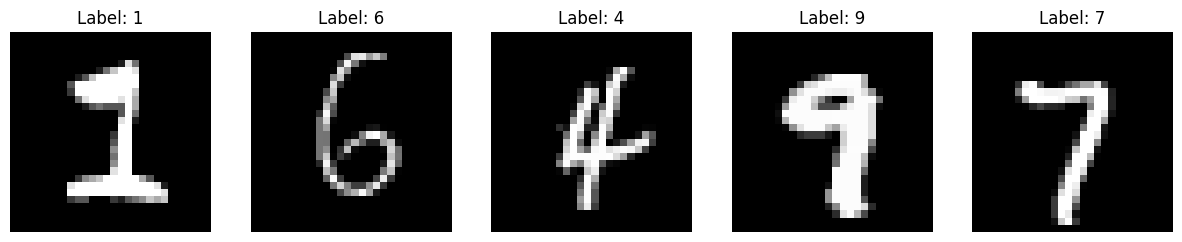

In [7]:
# Récupérer les 5 premières images et leurs étiquettes
batch = next(iter(train_loader))
images = batch[0][:5]
labels = batch[1][:5]

# Afficher les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.show()

### Construction d'une classe

In [8]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super(ConvNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(n_kernels, n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(n_kernels * 4 * 4, 50),
            nn.ReLU(),
            nn.Linear(50, output_size)
        )
        
    
    def forward(self, x):
        return self.net(x)

### Fonction train

In [9]:
def train(model, train_loader, perm, n_epoch=1):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())

    for epoch in range(n_epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Step: {batch_idx}, Loss: {loss.item()}')

### Fonction test

In [10]:
def test(model, test_loader, perm):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            
            logits = model(data)
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()
            pred = torch.argmax(logits, dim=1)
            correct += pred.eq(target).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f'Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


### Lancement de l'entrainement

In [13]:
n_kernels = 6
input_size = 28*28
output_size = 10
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet, train_loader, torch.arange(0, 784))
test(convnet, test_load, torch.arange(0, 784))

Parameters=6.422K
Epoch: 0, Step: 0, Loss: 2.295722484588623
Epoch: 0, Step: 100, Loss: 0.5455559492111206
Epoch: 0, Step: 200, Loss: 0.4954688251018524
Epoch: 0, Step: 300, Loss: 0.21575330197811127
Epoch: 0, Step: 400, Loss: 0.2976612150669098
Epoch: 0, Step: 500, Loss: 0.2254517674446106
Epoch: 0, Step: 600, Loss: 0.17761041224002838
Epoch: 0, Step: 700, Loss: 0.05773052200675011
Epoch: 0, Step: 800, Loss: 0.17278288304805756
Epoch: 0, Step: 900, Loss: 0.03685908764600754
Average loss: 0.1168, Accuracy: 0.9618


### Nouveau modèle : le perceptron multi-couches

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size)
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.net(x)

### Fonction train

In [16]:
def mlp_train(model, train_loader, perm, n_epoch=1):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())

    for epoch in range(n_epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Step: {batch_idx}, Loss: {loss.item()}')



### Fonction test

In [17]:
def mlp_test(model, test_loader, perm):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            
            logits = model(data)
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()
            pred = torch.argmax(logits, dim=1)
            correct += pred.eq(target).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f'Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


### Lancement de l'entraînement

In [20]:
input_size = 28*28
output_size = 10
n_hidden = 8
mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")
mlp_train(mlp, train_loader, torch.arange(0, 784))
mlp_test(mlp, test_load, torch.arange(0, 784))

Parameters=6.442K
Epoch: 0, Step: 0, Loss: 2.328458786010742
Epoch: 0, Step: 100, Loss: 1.3120949268341064
Epoch: 0, Step: 200, Loss: 0.9425003528594971
Epoch: 0, Step: 300, Loss: 0.5962355136871338
Epoch: 0, Step: 400, Loss: 0.5497626662254333
Epoch: 0, Step: 500, Loss: 0.5512579679489136
Epoch: 0, Step: 600, Loss: 0.36224350333213806
Epoch: 0, Step: 700, Loss: 0.8227468729019165
Epoch: 0, Step: 800, Loss: 0.3002803921699524
Epoch: 0, Step: 900, Loss: 0.5813274383544922
Average loss: 0.4043, Accuracy: 0.8804


Bien que le MLP soit plus simple et flexible, il n'est pas aussi bien adapté pour traiter des données structurées en grille comme les images. Les CNNs, en revanche, sont spécifiquement conçus pour exploiter les structures spatiales des images, ce qui les rend beaucoup plus efficaces pour les tâches de vision par ordinateur

In [23]:
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")
mlp_train(mlp, train_loader, torch.randperm(784))
mlp_test(mlp, test_load, torch.randperm(784))
print("-----------------")
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet, train_loader, torch.randperm(784))
test(convnet, test_load, torch.randperm(784))

Parameters=6.442K
Epoch: 0, Step: 0, Loss: 2.621769428253174
Epoch: 0, Step: 100, Loss: 0.7604302763938904
Epoch: 0, Step: 200, Loss: 0.5023573637008667
Epoch: 0, Step: 300, Loss: 0.4332887828350067
Epoch: 0, Step: 400, Loss: 0.29884347319602966
Epoch: 0, Step: 500, Loss: 0.35487493872642517
Epoch: 0, Step: 600, Loss: 0.3657197058200836
Epoch: 0, Step: 700, Loss: 0.19481995701789856
Epoch: 0, Step: 800, Loss: 0.5254439115524292
Epoch: 0, Step: 900, Loss: 0.31269392371177673
Average loss: 3.3356, Accuracy: 0.0693
-----------------
Parameters=6.422K
Epoch: 0, Step: 0, Loss: 4.334047317504883
Epoch: 0, Step: 100, Loss: 1.4392523765563965
Epoch: 0, Step: 200, Loss: 0.6984210014343262
Epoch: 0, Step: 300, Loss: 0.8331004977226257
Epoch: 0, Step: 400, Loss: 0.4615146219730377
Epoch: 0, Step: 500, Loss: 0.6334160566329956
Epoch: 0, Step: 600, Loss: 0.6140337586402893
Epoch: 0, Step: 700, Loss: 0.41066673398017883
Epoch: 0, Step: 800, Loss: 0.5583491921424866
Epoch: 0, Step: 900, Loss: 0.60918

Cette expérience démontre clairement l'importance de la structure spatiale des images pour les CNNs. Les CNNs sont conçus pour tirer parti des relations locales entre les pixels, ce qui leur donne un avantage significatif sur les MLPs pour les tâches de vision par ordinateur. Cependant, lorsque cette structure est détruite par une permutation aléatoire, les CNNs perdent cet avantage et leurs performances chutent considérablement.

Les MLPs, bien que moins dépendants de la structure spatiale, ne sont pas capables de compenser cette perte car ils n'exploitent pas les relations spatiales de manière efficace.

In [24]:
torch.save(convnet.state_dict(), "convnet.pth")